In [1]:
print("Hello, world!")
print("Starting project...")

Hello, world!
Starting project...


In [68]:
print("Importing libraries...")
#imports 
import numpy as np
import collections as cl
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import seaborn as sns
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import precision_score, recall_score, confusion_matrix, plot_confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
print("Done importing libraries.")

Importing libraries...
Done importing libraries.


In [3]:
print("Importing dataset...")
data = pd.read_csv("Crimes - 2001 to present (25th mai 2020).csv", dtype=object)
print("Done importing dataset.")

Importing dataset...
Done importing dataset.


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4899981 entries, 0 to 4899980
Data columns (total 22 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   ID                    object
 1   Case Number           object
 2   Date                  object
 3   Block                 object
 4   IUCR                  object
 5   Primary Type          object
 6   Description           object
 7   Location Description  object
 8   Arrest                object
 9   Domestic              object
 10  Beat                  object
 11  District              object
 12  Ward                  object
 13  Community Area        object
 14  FBI Code              object
 15  X Coordinate          object
 16  Y Coordinate          object
 17  Year                  object
 18  Updated On            object
 19  Latitude              object
 20  Longitude             object
 21  Location              object
dtypes: object(22)
memory usage: 822.4+ MB


In [5]:
data.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,11034701,JA366925,01/01/2001 11:00:00 AM,016XX E 86TH PL,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,false,false,...,8,45,11,NaN,NaN,2001,08/05/2017 03:50:08 PM,NaN,NaN,NaN
1,11227287,JB147188,10/08/2017 03:00:00 AM,092XX S RACINE AVE,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,false,false,...,21,73,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
2,11227583,JB147595,03/28/2017 02:00:00 PM,026XX W 79TH ST,0620,BURGLARY,UNLAWFUL ENTRY,OTHER,false,false,...,18,70,05,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
3,11227293,JB147230,09/09/2017 08:17:00 PM,060XX S EBERHART AVE,0810,THEFT,OVER $500,RESIDENCE,false,false,...,20,42,06,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
4,11227634,JB147599,08/26/2017 10:00:00 AM,001XX W RANDOLPH ST,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,HOTEL/MOTEL,false,false,...,42,32,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN


In [6]:
# Feature engineering
# 1. Drop unused tables: ID, Case Number, Description, Block, Location, Location Description as we have too much location information
data = data.drop(['ID', 'Case Number', 'X Coordinate', 'Y Coordinate', 'Block', 'Updated On', 'Location', 'Description', 'Location Description'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4899981 entries, 0 to 4899980
Data columns (total 13 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   Date            object
 1   IUCR            object
 2   Primary Type    object
 3   Arrest          object
 4   Domestic        object
 5   Beat            object
 6   District        object
 7   Ward            object
 8   Community Area  object
 9   FBI Code        object
 10  Year            object
 11  Latitude        object
 12  Longitude       object
dtypes: object(13)
memory usage: 486.0+ MB


In [7]:
# We've eliminated 2020 to minimize the risk of possible anomalies happening in 2020 due to Covid-19
data['Year'] = pd.to_numeric(data['Year'])
data = data[(data.Year > 2014) & (data.Year < 2020)]

In [8]:
# See how many values are null before engineering
data_missing = data.isnull().sum()
print(data_missing)

Date                  0
IUCR                  0
Primary Type          0
Arrest                0
Domestic              0
Beat                  0
District              1
Ward                 22
Community Area        0
FBI Code              0
Year                  0
Latitude          18005
Longitude         18005
dtype: int64


In [9]:
perc_missing = round(100 * (data_missing / len(data)), 2)
print(perc_missing)

Date              0.0
IUCR              0.0
Primary Type      0.0
Arrest            0.0
Domestic          0.0
Beat              0.0
District          0.0
Ward              0.0
Community Area    0.0
FBI Code          0.0
Year              0.0
Latitude          1.4
Longitude         1.4
dtype: float64


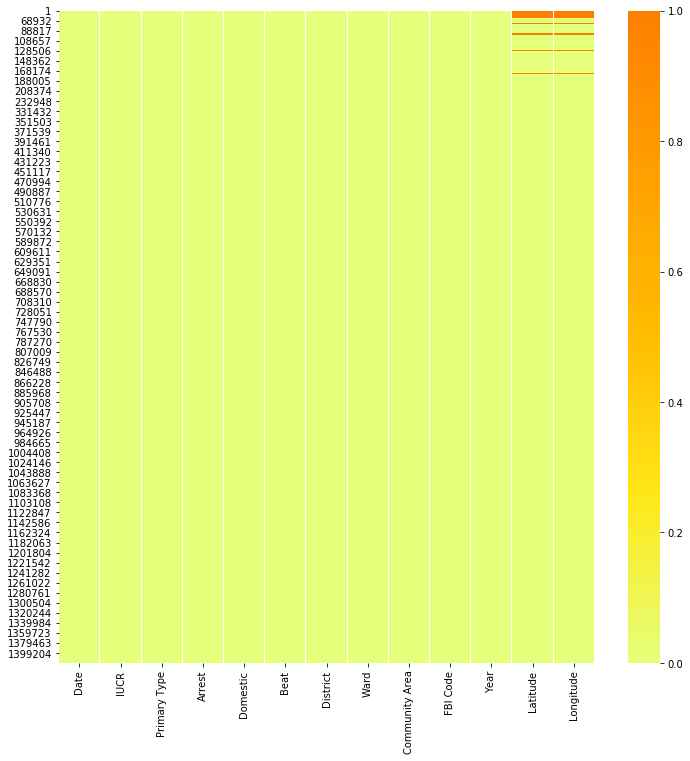

In [10]:
# Visualize how many values are null before engineering
plt.figure(figsize=(12, 12))
sns.heatmap(data.isnull(), cbar=True, cmap='Wistia')

In [11]:
# since the dataset is absolutely immense, we can easily drop the NaN rows. We will do so before sampling
data = data.dropna()

In [12]:
data['Arrest'] = pd.factorize(data['Arrest'])[0]

Number of cases ending without arrests: 999008
Number of cases ending with arrests: 265770


0    78.986826
1    21.013174
Name: Arrest, dtype: float64

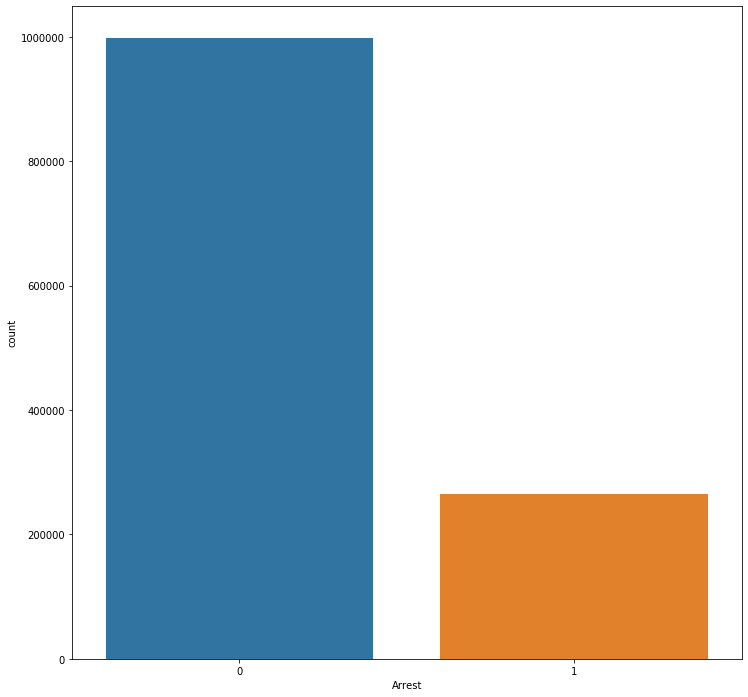

In [13]:
# types of crimes
plt.figure(figsize=(12, 12))
sns.countplot(data['Arrest'])
no, yes = data['Arrest'].value_counts()
print("Number of cases ending without arrests:", no)
print("Number of cases ending with arrests:", yes)

data['Arrest'].value_counts(normalize=True) * 100

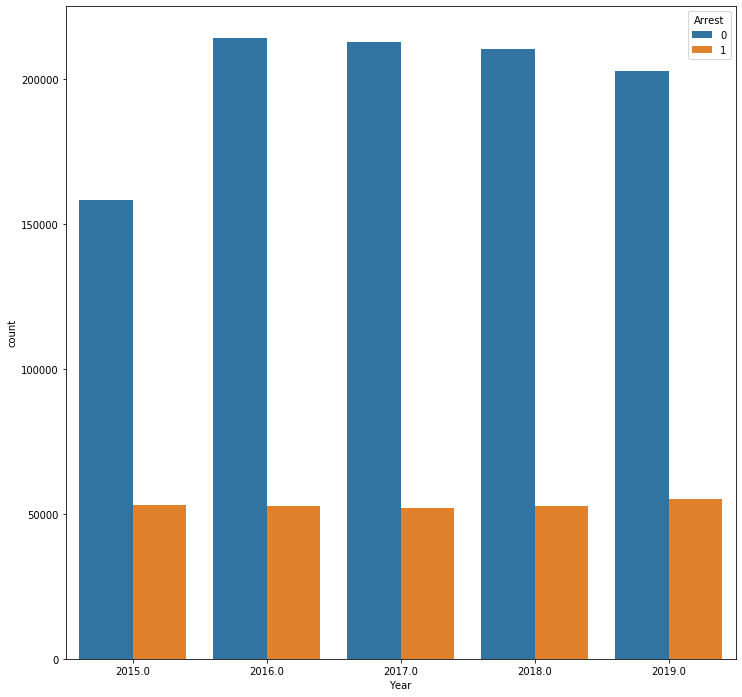

In [14]:
# types of crimes
plt.figure(figsize=(12, 12))
sns.countplot(x='Year', hue='Arrest', data=data)

In [15]:
# Dataset is too huge and takes too long to train on all of it, we're going to sample 100.000. Also, we're going to duplicate the sampled data in order to apply
# supervised and unsupervised algorithms on the same sample
# Random sampling
data = data.sample(n=100000)

In [16]:
# Since we loaded the model with object as dtype (for faster loading), 
# we're going to specify all the types manually
data['DateTime'] = pd.to_datetime(data['Date'])
data['Year'] = data['DateTime'].dt.year
data['Month'] = data['DateTime'].dt.month
data['Day'] = data['DateTime'].dt.day
data['Hour'] = data['DateTime'].dt.hour

data = data.drop(['Date'], axis=1)
data = data.drop(['DateTime'], axis=1)

In [17]:
# Convert categorical attributes to Numerical
data['IUCR'] = pd.factorize(data['IUCR'])[0]
data['Primary Type'] = pd.factorize(data['Primary Type'])[0]
data['Domestic'] = pd.factorize(data['Domestic'])[0]
data['Beat'] = pd.factorize(data['Beat'])[0]
data['District'] = pd.factorize(data['District'])[0]
data['Ward'] = pd.factorize(data['Ward'])[0]
data['Community Area'] = pd.factorize(data['Community Area'])[0]
data['FBI Code'] = pd.factorize(data['FBI Code'])[0]
data['Latitude'] = pd.factorize(data['Latitude'])[0]
data['Longitude'] = pd.factorize(data['Longitude'])[0]

In [18]:
# Scaling the features
data_target = data['Arrest']
data_train = data.drop(['Arrest'], axis = 1)
scaled_features = StandardScaler().fit_transform(data_train.values)
data_scaled = pd.DataFrame(scaled_features, index=data_train.index, columns=data_train.columns)
data_scaled['Arrest'] = data_target

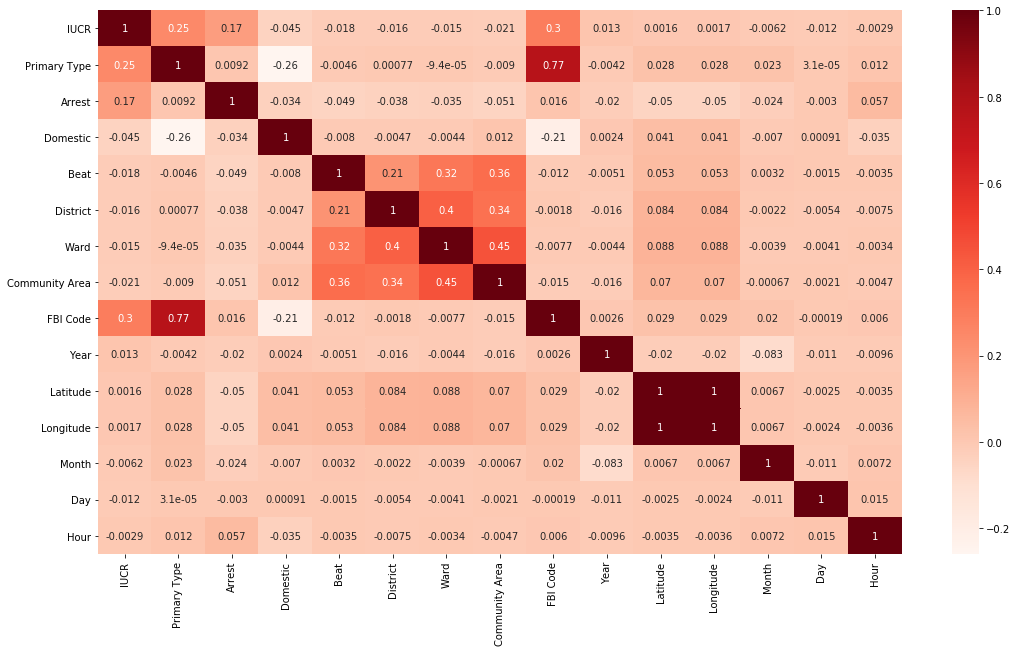

In [19]:
# Using Pearson correlation
plt.figure(figsize=(18, 10))
correlation = data.corr()
sns.heatmap(correlation, annot=True, cmap=plt.cm.Reds)
plt.show()

In [20]:
# SUPERVISED LEARNING
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 157729 to 329215
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   IUCR            100000 non-null  int64
 1   Primary Type    100000 non-null  int64
 2   Arrest          100000 non-null  int64
 3   Domestic        100000 non-null  int64
 4   Beat            100000 non-null  int64
 5   District        100000 non-null  int64
 6   Ward            100000 non-null  int64
 7   Community Area  100000 non-null  int64
 8   FBI Code        100000 non-null  int64
 9   Year            100000 non-null  int64
 10  Latitude        100000 non-null  int64
 11  Longitude       100000 non-null  int64
 12  Month           100000 non-null  int64
 13  Day             100000 non-null  int64
 14  Hour            100000 non-null  int64
dtypes: int64(15)
memory usage: 12.2 MB


In [21]:
X = data_scaled.drop(['Arrest'], axis = 1)
y = data_scaled['Arrest']

In [22]:
# spliting data into training: 50%, validation: 25% and testing: 25%
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.5, train_size = 0.5, random_state = 42)
X_validation, X_test, y_validation, y_test = train_test_split(X_validation, y_validation, test_size = 0.5, train_size = 0.5, random_state = 42)



[[19871  5129]
 [    0     0]]
0.79484
              precision    recall  f1-score   support

           0       0.79      1.00      0.89     19871
           1       0.00      0.00      0.00      5129

    accuracy                           0.79     25000
   macro avg       0.40      0.50      0.44     25000
weighted avg       0.63      0.79      0.70     25000



/home/irikos/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


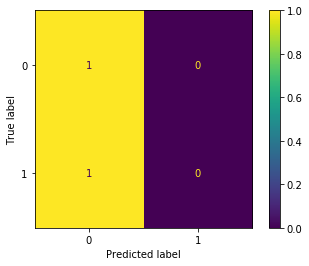

In [23]:
# Baseline definition
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
predicted = dummy_clf.predict(X_test)
acc = dummy_clf.score(X_test, y_test)

# cf_matrix = confusion_matrix(predicted, y_test)
# print(cf_matrix)
print(acc)
print(classification_report(y_test, predicted))
plot_confusion_matrix(dummy_clf, X_test, y_test, normalize='true')
plt.show()

In [24]:
# Hyperparameter tuning KNN
# GridSearchCV
grid_params_knn = {
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto'],
    'n_neighbors': range(1, 50),
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski', 'seuclidean', 'mahalanobis'],
    
}

grid_search_KNN = GridSearchCV(KNeighborsClassifier(), grid_params_knn, verbose=1, cv=5, n_jobs=-1)


grid_search_results_KNN = grid_search_KNN.fit(X_validation, y_validation)

Fitting 5 folds for each of 588 candidates, totalling 2940 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 22.1min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 28.9min
[Parallel(n_jobs=-1)]: Done 2925 out of 2940 | elapsed: 32.3min remaining:    9.9s
[Parallel(n_jobs=-1)]: Done 2940 out of 2940 | elapsed: 32.3min finished


In [25]:
print(grid_search_results_KNN.best_estimator_)
print(grid_search_results_KNN.best_score_)
print(grid_search_results_KNN.score)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='distance')
0.8318
<bound method BaseSearchCV.score of GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'algorithm': ['auto'],
                         'metric': ['euclidean', 'manhattan', 'chebyshev',
                                    'minkowski', 'seuclidean', 'mahalanobis'],
                         'n_neighbors': range(1, 50),
                         'weights': ['uniform', 'distance']},
             pre_dispatch='

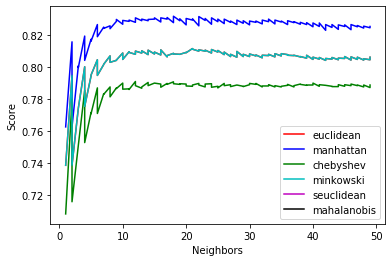

In [26]:
# Ploting the results
results = grid_search_results_KNN.cv_results_['params']
scores = grid_search_results_KNN.cv_results_['split2_test_score']
dic = defaultdict(list)
for i in range(len(results)):
    dic[results[i]['metric']].append((results[i]['n_neighbors'], scores[i]))
    
colors = {
    'euclidean': 'r',
    'manhattan': 'b',
    'chebyshev': 'g',
    'minkowski': 'c',
    'seuclidean': 'm',
    'mahalanobis': 'k'
}

# plt.figure(figsize=(20, 20))
for key in dic:
    neighbors = [x[0] for x in dic[key]]
    score = [x[1] for x in dic[key]]
    plt.plot(neighbors, score, colors[key], label=key)

legend = ['euclidean', 'manhattan', 'chebyshev', 'minkowski', 'seuclidean', 'mahalanobis']
plt.legend(legend)
plt.xlabel('Neighbors')
plt.ylabel('Score')
plt.show()

[[19460  3383]
 [  411  1746]]
0.84824
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     19871
           1       0.81      0.34      0.48      5129

    accuracy                           0.85     25000
   macro avg       0.83      0.66      0.70     25000
weighted avg       0.84      0.85      0.82     25000



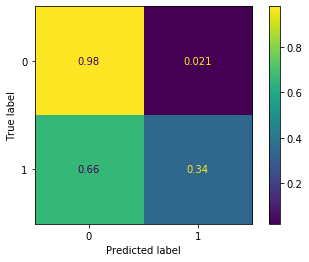

In [27]:
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='distance')
knn.fit(X_train, y_train)
knn_y_predict = knn.predict(X_test)

knn_acc = accuracy_score(y_test, knn_y_predict)
knn_cf_matrix = confusion_matrix(knn_y_predict, y_test)
knn_report = classification_report(y_test, knn_y_predict)

print(knn_cf_matrix)
print(knn_acc)
print(knn_report)
plot_confusion_matrix(knn, X_test, y_test, normalize='true')
plt.show()

In [28]:
# Hyperparameter tuning RF
# GridSearchCV
grid_params_rf = {
    'n_estimators': [50, 100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [None, 4, 5, 6, 7, 8],
    'criterion' :['gini', 'entropy'],
    'bootstrap': ['False', 'True']
}

grid_search_rf = GridSearchCV(RandomForestClassifier(), grid_params_rf, verbose=1, cv=5, n_jobs=-1)

grid_search_rf_results = grid_search_rf.fit(X_validation, y_validation)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 19.3min finished


In [29]:
print(grid_search_rf_results.best_estimator_)
print(grid_search_rf_results.best_score_)

RandomForestClassifier(bootstrap='False', ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
0.8821200000000001


[[19524  2351]
 [  347  2778]]
0.89208
              precision    recall  f1-score   support

           0       0.89      0.98      0.94     19871
           1       0.89      0.54      0.67      5129

    accuracy                           0.89     25000
   macro avg       0.89      0.76      0.80     25000
weighted avg       0.89      0.89      0.88     25000



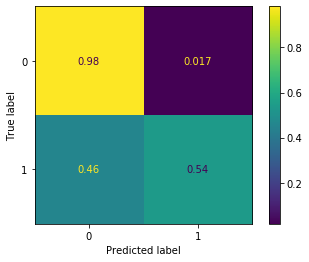

In [30]:
# Random Forest
rf = RandomForestClassifier(bootstrap='False', ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

rf.fit(X_train, y_train)
rf_y_predict = rf.predict(X_test)

rf_acc = accuracy_score(y_test, rf_y_predict)
rf_cf_matrix = confusion_matrix(rf_y_predict, y_test)
rf_report = classification_report(y_test, rf_y_predict)

print(rf_cf_matrix)
print(rf_acc)
print(rf_report)

plot_confusion_matrix(rf, X_test, y_test, normalize='true')
plt.show()

In [31]:
Xu = data_scaled.drop(['Arrest'], axis = 1)
yu = data_scaled['Arrest']
yu = pd.factorize(yu)[0]
# spliting data into training: 70% and testing: 30%
Xu_train, Xu_test, yu_train, yu_test = train_test_split(Xu, yu, test_size = 0.3, train_size = 0.7, random_state = 42)


In [32]:
pca_train = PCA(n_components=2).fit_transform(Xu_train)
pca_test = PCA(n_components=2).fit_transform(Xu_test)

Zeros: 55276
Ones: 14724


0
10000
20000
30000
40000
50000
60000


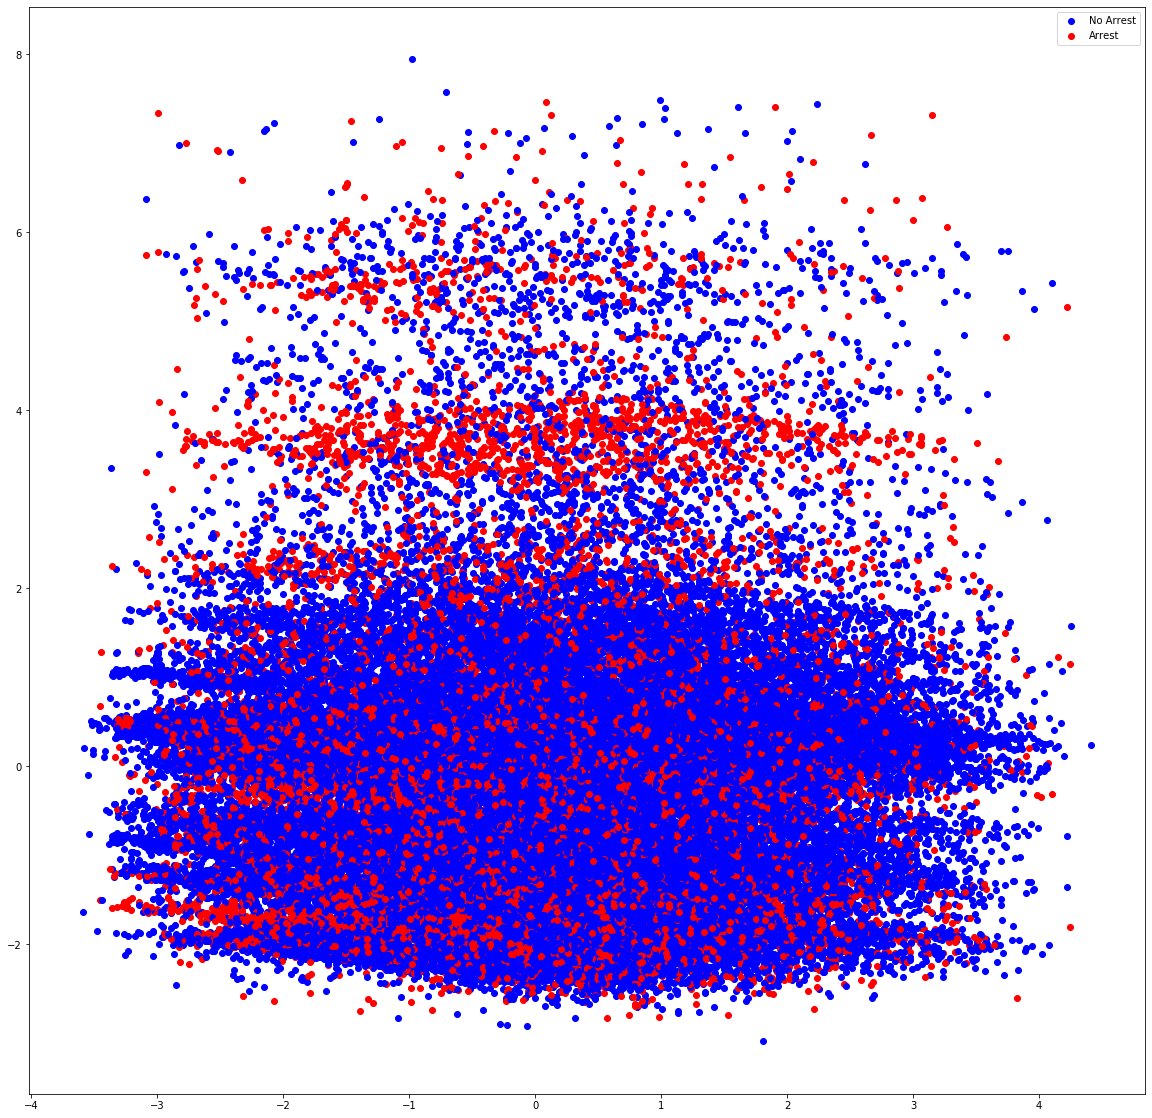

In [54]:
plt.figure(figsize=(20, 20))

length = pca_train.shape[0]
for i in range(0, length):
    if (i % 10000 == 0):
        print(i)
    if (yu_train[i] == 0):
        c1 = plt.scatter(pca_train[i,0], pca_train[i,1],c='b')
    if (yu_train[i] == 1):
        c2 = plt.scatter(pca_train[i,0], pca_train[i,1],c='r')

legend = ['No Arrest', 'Arrest']
plt.legend(legend)
plt.show()

0
10000
20000


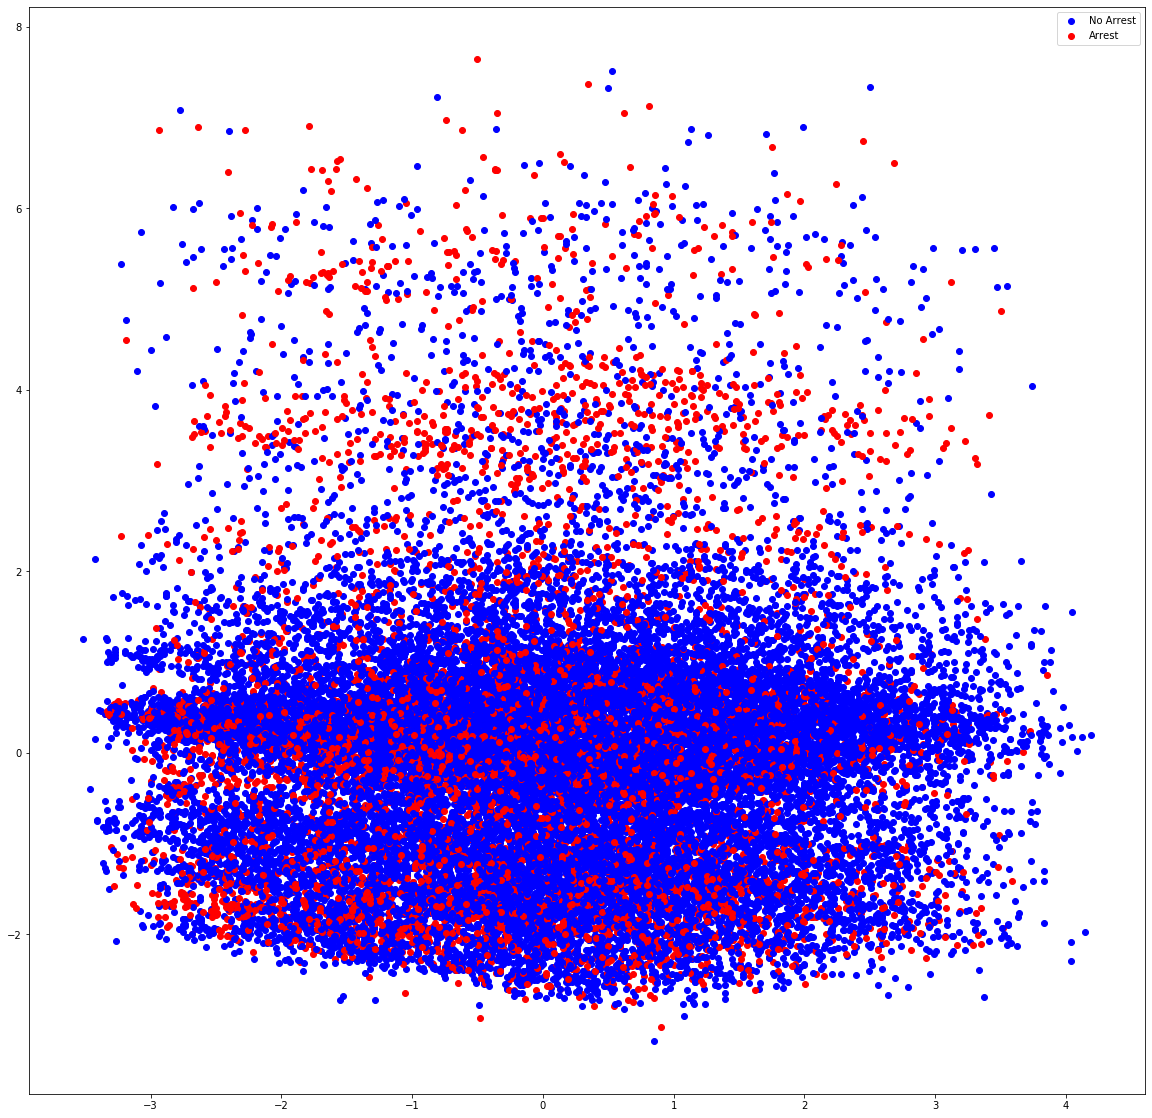

In [55]:
plt.figure(figsize=(20, 20))

length = pca_test.shape[0]
for i in range(0, length):
    if (i % 10000 == 0):
        print(i)
    if (yu_test[i] == 0):
        c1 = plt.scatter(pca_test[i,0], pca_test[i,1],c='b')
    if (yu_test[i] == 1):
        c2 = plt.scatter(pca_test[i,0], pca_test[i,1],c='r')

legend = ['No Arrest', 'Arrest']
plt.legend((c1, c2), legend)
plt.show()

0
10000
20000
30000
40000
50000
60000


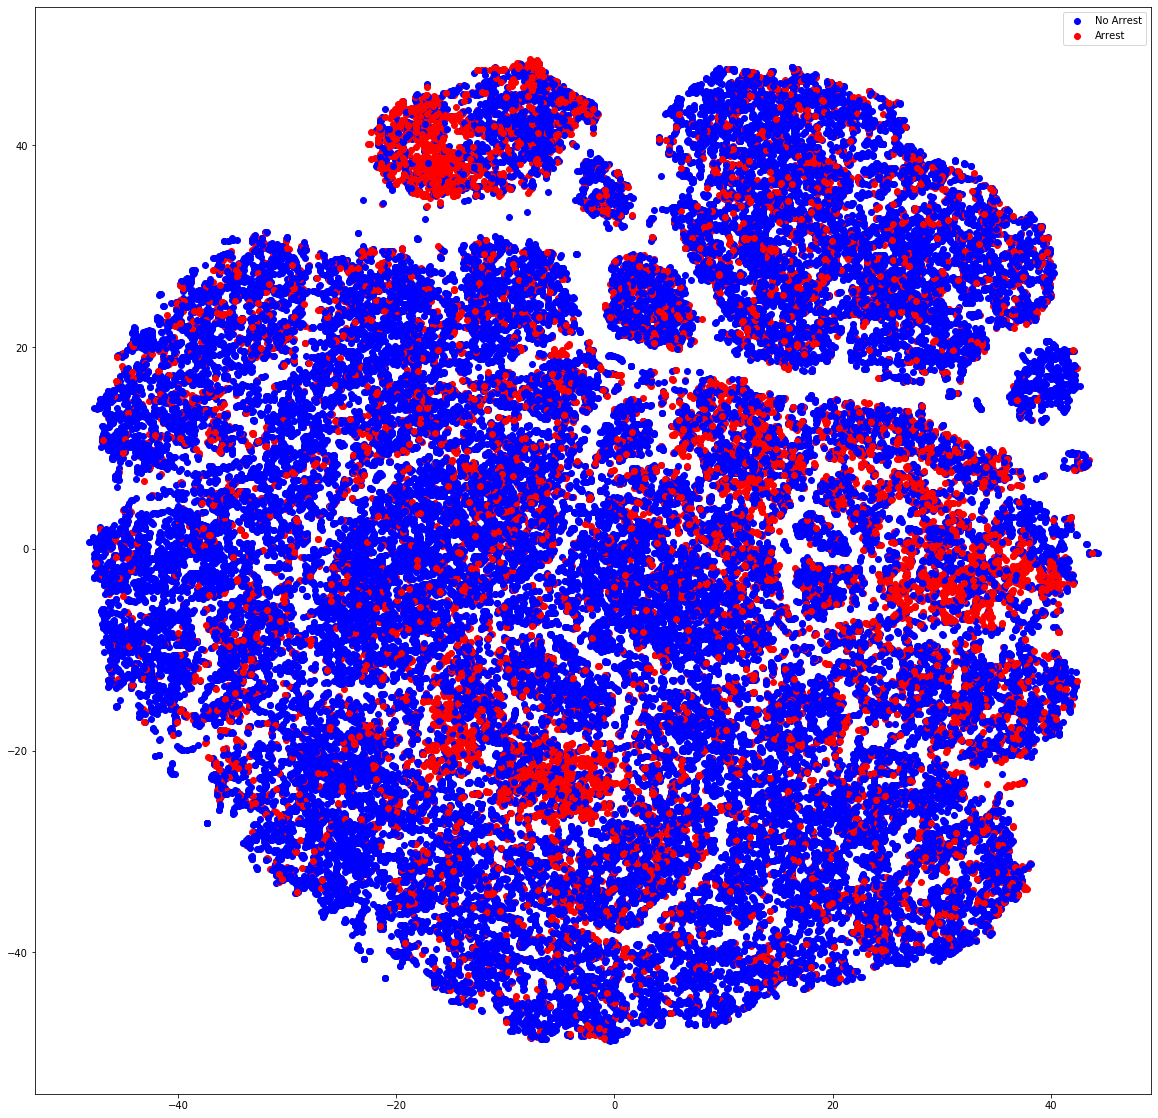

In [56]:
plt.figure(figsize=(20, 20))

length = tsne_train.shape[0]
for i in range(0, length):
    if (i % 10000 == 0):
        print(i)
    if (yu_train[i] == 0):
        c1 = plt.scatter(tsne_train[i,0], tsne_train[i,1],c='b')
    if (yu_train[i] == 1):
        c2 = plt.scatter(tsne_train[i,0], tsne_train[i,1],c='r')
        
legend = ['No Arrest', 'Arrest']
plt.legend((c1, c2), legend)
plt.show()

0
10000
20000


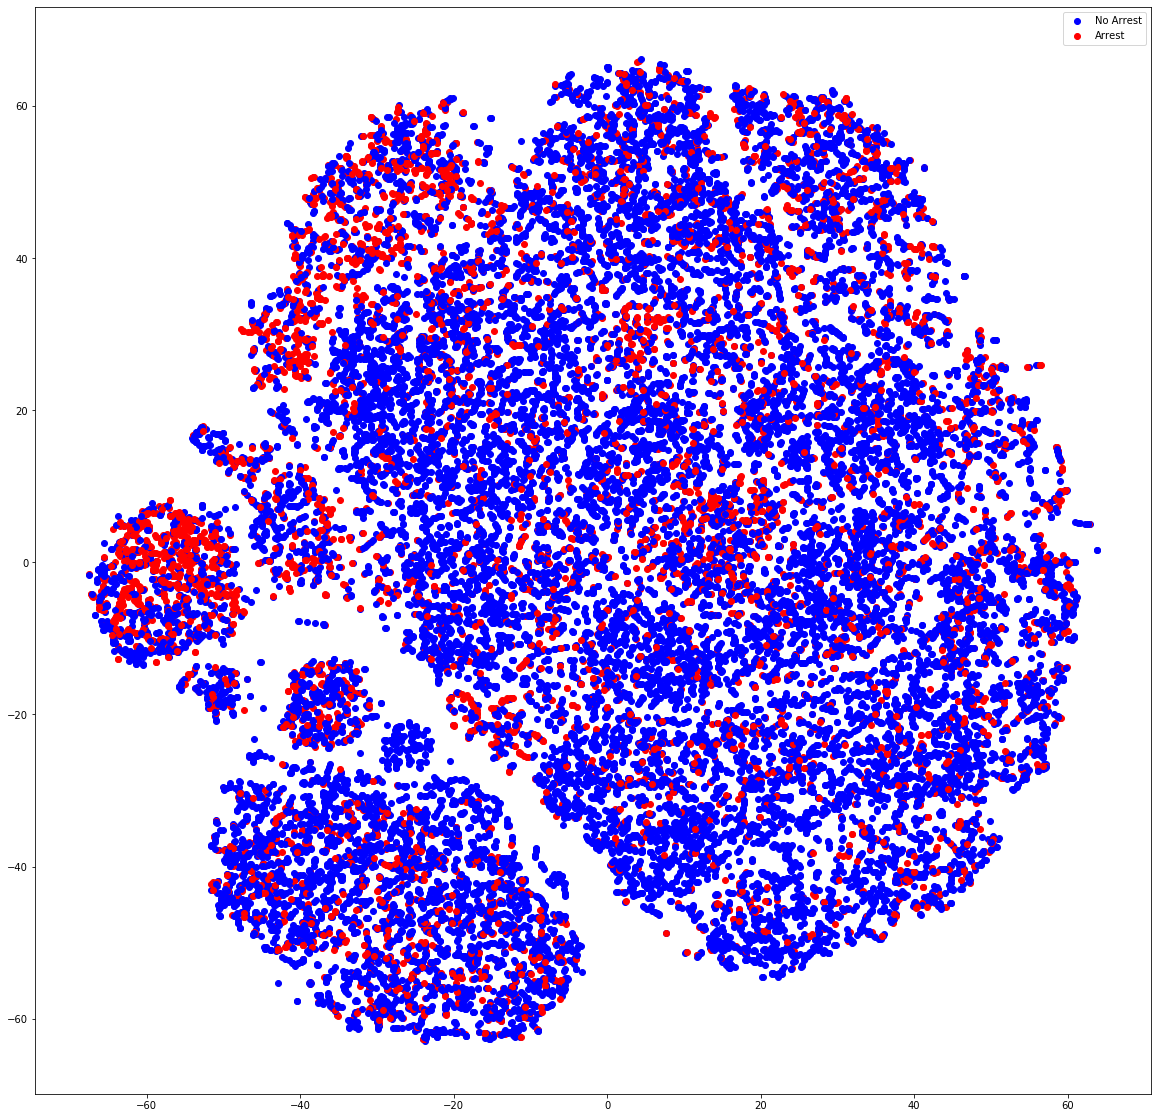

In [57]:
plt.figure(figsize=(20, 20))

length = tsne_test.shape[0]
for i in range(0, length):
    if (i % 10000 == 0):
        print(i)
    if (yu_test[i] == 0):
        c1 = plt.scatter(tsne_test[i,0], tsne_test[i,1],c='b')
    if (yu_test[i] == 1):
        c2 = plt.scatter(tsne_test[i,0], tsne_test[i,1],c='r')
        
legend = ['No Arrest', 'Arrest']
plt.legend((c1, c2), legend)
plt.show()

In [ ]:
# data must pe mapped to 3D using PCA or t-SNE
def plot_in_3D(data, target, legend, colors, figsize=(20,20)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    length = data.shape[0]
    for i in range(0, length):
        if (i % 10000 == 0): # just to see how long it takes
            print(i)
        if (target[i] == 0):
            c1 = ax.scatter(data[i,0], data[i,1], data[i,2] ,c=colors[0])
        if (target[i] == 1):
            c2 = ax.scatter(data[i,0], data[i,1], data[i,2], c=colors[1])

    plt.legend((c1, c2),legend)
    plt.show()
    
# data must pe mapped to 2D using PCA or t-SNE
def plot_in_2D(data, target, legend, colors, figsize=(20,20)):
    fig = plt.figure(figsize=figsize)
    length = data.shape[0]
    
    for i in range(0, length):
        if (i % 10000 == 0): # just to see how long it takes
            print(i)
        if (target[i] == 0):
            c1 = plt.scatter(data[i,0], data[i,1],c=colors[0])
        if (target[i] == 1):
            c2 = plt.scatter(data[i,0], data[i,1],c=colors[1])

    plt.legend((c1, c2), legend)
    plt.show()

In [49]:
tsne_train = TSNE(n_components=2).fit_transform(Xu_train)
tsne_test = TSNE(n_components=2).fit_transform(Xu_test)

In [87]:
pca_train_3D = PCA(n_components=3).fit_transform(Xu_train)
pca_test_3D = PCA(n_components=3).fit_transform(Xu_test)

In [78]:
tsne_train_3d = TSNE(n_components=3).fit_transform(Xu_train)
tsne_test_3d = TSNE(n_components=3).fit_transform(Xu_test)

In [ ]:
legend = ['No Arrest', 'Arrest']
colors = ['b', 'r']
plot_in_3D(pca_test_3D, yu_test, legend, colors)
plot_in_3D(pca_train_3D, yu_train, legend, colors)

plot_in_3D(tsne_test_3d, yu_test, legend, colors)
plot_in_3D(tsne_train_3d, yu_train, legend, colors)

0


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

length = tsne_test_3d.shape[0]
for i in range(0, int(length/ 100)):
    if (i % 10000 == 0):
        print(i)
    if (yu_train[i] == 0):
        c1 = ax.scatter(tsne_test_3d[i,0], tsne_test_3d[i,1], tsne_test_3d[i,2] ,c='b')
    if (yu_train[i] == 1):
        c2 = ax.scatter(tsne_test_3d[i,0], tsne_test_3d[i,1], tsne_test_3d[i,2], c='r')

legend = ['No Arrest', 'Arrest']
plt.legend(legend)
plt.show()

In [431]:
# Unsupervised learning
km = KMeans(n_clusters=2, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
km.fit(X_test)
y_km = km.predict(X_test)

In [433]:
centers = km.cluster_centers_

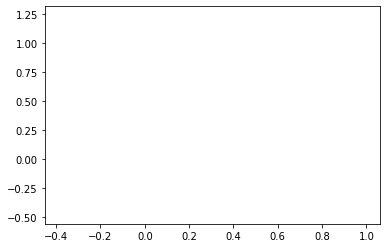

In [434]:
# plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0)


In [442]:
accuracy_score(y_test, y_km)

array([1, 1, 0, ..., 1, 1, 1])

In [407]:
finalDf

,PC1,PC2,Arrest
0,2.168891,2.563390,NaN
1,4.113358,1.162028,NaN
2,-0.536835,-2.123108,NaN
3,-0.410680,2.349794,NaN
4,2.632301,-1.552023,NaN
...,...,...,...
2306922,NaN,NaN,0.516341
2307286,NaN,NaN,0.516341
2309874,NaN,NaN,0.516341
2310314,NaN,NaN,0.516341


In [ ]:
# Balanced sampling
g = data.groupby('Arrest')
g = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))
